In [30]:
import json
import numpy as np
import tqdm
import networkx as nx
import pandas as pd
import ast
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import scipy.sparse as sp
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from collections import defaultdict
from typing import Any, Iterable, List, Optional, Tuple, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset

from torch_geometric.data import Data, Dataset, Batch
from torch_geometric.nn import GATConv, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_networkx, to_networkx, to_dense_adj, dense_to_sparse, subgraph
from torch_geometric.utils import batched_negative_sampling

from transformers import GPT2Tokenizer, GPT2Config, GPT2Model

import statsmodels.api as sm

device = "cpu"  #"cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(39)

## Just looking at Ratios part

In [27]:
### Data Loading ###

root = "data/"

# I'm the only one going to be using these so I didn't bother making it generalizable
# load
metadata = pd.read_csv(root + "MoviesDataset/movies_metadata.csv")
links = pd.read_csv(root + "MoviesDataset/links.csv")
credits = pd.read_csv("data/MoviesDataset/credits.csv")

# cleaning
movie_data = pd.merge(credits, metadata, on='id', how='inner')
movie_data = movie_data[~pd.isnull(movie_data['imdb_id'])]
movie_data['imdb_id'] = movie_data['imdb_id'].apply(lambda x: x[2:])

# add info about cast 
movie_data['num_female'] = movie_data['cast'].apply(lambda x:
    len([y for y in ast.literal_eval(x) if y['gender'] == 1]))
movie_data['num_characters'] = movie_data['cast'].apply(lambda x: len(ast.literal_eval(x)))
movie_data['female_ratio'] = movie_data['num_female'] / movie_data['num_characters']
movie_data['female_ratio'] = movie_data['female_ratio'].fillna(0)

"""
save_columns = [
    'genres', 'overview', 'popularity', 'release_date', 'revenue', 'runtime', 'vote_average',
    'vote_count', 'num_female', 'female_ratio', 'title', 'cast', 'crew'
]
movie_data = movie_data[save_columns]
"""

# dummy columns for genres
all_genres = {}
for idx, row in movie_data.iterrows():
    genres = ast.literal_eval(row['genres'])
    for x in genres:
        if x['name'] not in all_genres:
            all_genres[x['name']] = 0
        all_genres[x['name']] += 1
        
for genre in all_genres.keys():
    movie_data[genre] = movie_data['genres'].apply(lambda x: int(any([y['name'] == genre for y in ast.literal_eval(x)])))

# additional cleaning
# log revenue and vote_count since they're skewed
movie_data['revenue'] = movie_data['revenue'] / 10000
movie_data['revenue'][movie_data['revenue'] == 0] = movie_data['revenue'].mean()
movie_data['revenue'] = np.log(movie_data['revenue'])

#movie_data['vote_count'] = movie_data['vote_count'] / 100
movie_data['vote_count'][movie_data['vote_count'] == 0] = movie_data['vote_count'].mean()
movie_data['vote_count'] = np.log(movie_data['vote_count'])

# Release Date 
movie_data['release_date'] = movie_data['release_date'].apply(lambda x: int(x[:4]) if isinstance(x, str) else x)
num_na_releasedate = movie_data['release_date'].isna().sum()
movie_data['release_date'] = movie_data['release_date'].fillna(movie_data['release_date'].mean())
earliest_movie_releasedate = movie_data['release_date'].min()
movie_data['release_date'] = movie_data['release_date'] - movie_data['release_date'].min()

# split release date into percentile groups
# helps get around the horrible left skew in release date
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
movie_data['year>=p0.1'] = np.array(movie_data['release_date'] > movie_data['release_date'].quantile(0.1)).astype(int)
movie_data['year>=p0.25'] = np.array(movie_data['release_date'] > movie_data['release_date'].quantile(0.25)).astype(int)
movie_data['year>=p0.5'] = np.array(movie_data['release_date'] > movie_data['release_date'].quantile(0.5)).astype(int)
movie_data['year>=p0.75'] = np.array(movie_data['release_date'] > movie_data['release_date'].quantile(0.75)).astype(int)
movie_data['year>=p0.9'] = np.array(movie_data['release_date'] > movie_data['release_date'].quantile(0.9)).astype(int)

feat_columns = list(movie_data.columns)
feat_columns.remove('genres')
feat_columns.remove('overview')

C:\Users\shirl\AppData\Local\Temp\ipykernel_76176\2923966711.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['revenue'][movie_data['revenue'] == 0] = movie_data['revenue'].mean()
C:\Users\shirl\AppData\Local\Temp\ipykernel_76176\2923966711.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['vote_count'][movie_data['vote_count'] == 0] = movie_data['vote_count'].mean()


In [31]:
# number of release dates na that have to be filled in with the mean
num_na_releasedate / len(movie_data)

0.0018453021682300476

In [37]:
ratio_model = sm.OLS(movie_data['female_ratio'], 
                      sm.add_constant(movie_data[['year>=p0.25', 'year>=p0.5', 'year>=p0.75']])).fit()
ratio_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           female_ratio   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     67.81
Date:                Mon, 28 Nov 2022   Prob (F-statistic):           9.59e-44
Time:                        01:43:50   Log-Likelihood:                 15417.
No. Observations:               45521   AIC:                        -3.083e+04
Df Residuals:                   45517   BIC:                        -3.079e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1803      0.002    111.805      0.000       0.177       0.183
year>=p0.25     0.0216      0.002      9.542      0.000       0.017       0.026
year>=p0.5      0.0036      0.002      1.582      0.114      -0.001       0.008
year>=p0.75    -0.0243      0.002    -10.525      0.000      -0.029      -0.020
==============================================================================
Omnibus:                     6562.715   Durbin-Watson:                   1.822
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10809.903
Skew:                           0.982   Prob(JB):                         0.00
Kurtosis:                       4.358   Cond. No.                         5.39
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
ratio_model = sm.RLM(movie_data['female_ratio'], 
                      sm.add_constant(movie_data[['release_date']])).fit()
ratio_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:           female_ratio   No. Observations:                45521
Model:                            RLM   Df Residuals:                    45519
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 28 Nov 2022                                         
Time:                        01:42:23                                         
No. Iterations:                    16                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1675      0.004     44.110      0.000       0.160       0.175
release_date     0.0001   3.16e-05      3.616      0.000    5.23e-05       0.000
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

<AxesSubplot:xlabel='release_date', ylabel='female_ratio'>

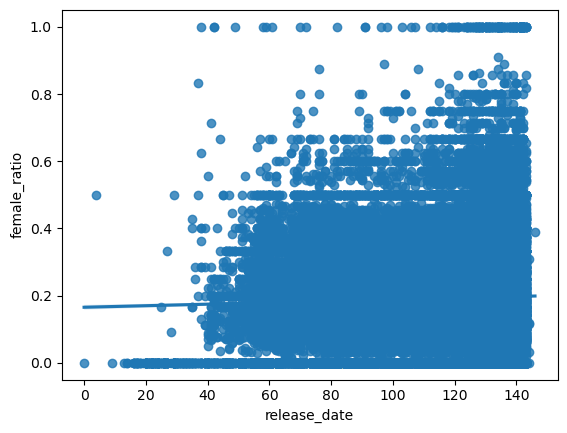

In [36]:
sns.regplot(movie_data, x='release_date', y='female_ratio')

(array([134., 163., 235., 197., 228., 257., 140.,  95., 116.,  36.,  74.,
         26.,  12.,   9.,   2.,   0.,   1.,   1.,   0.,   2.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

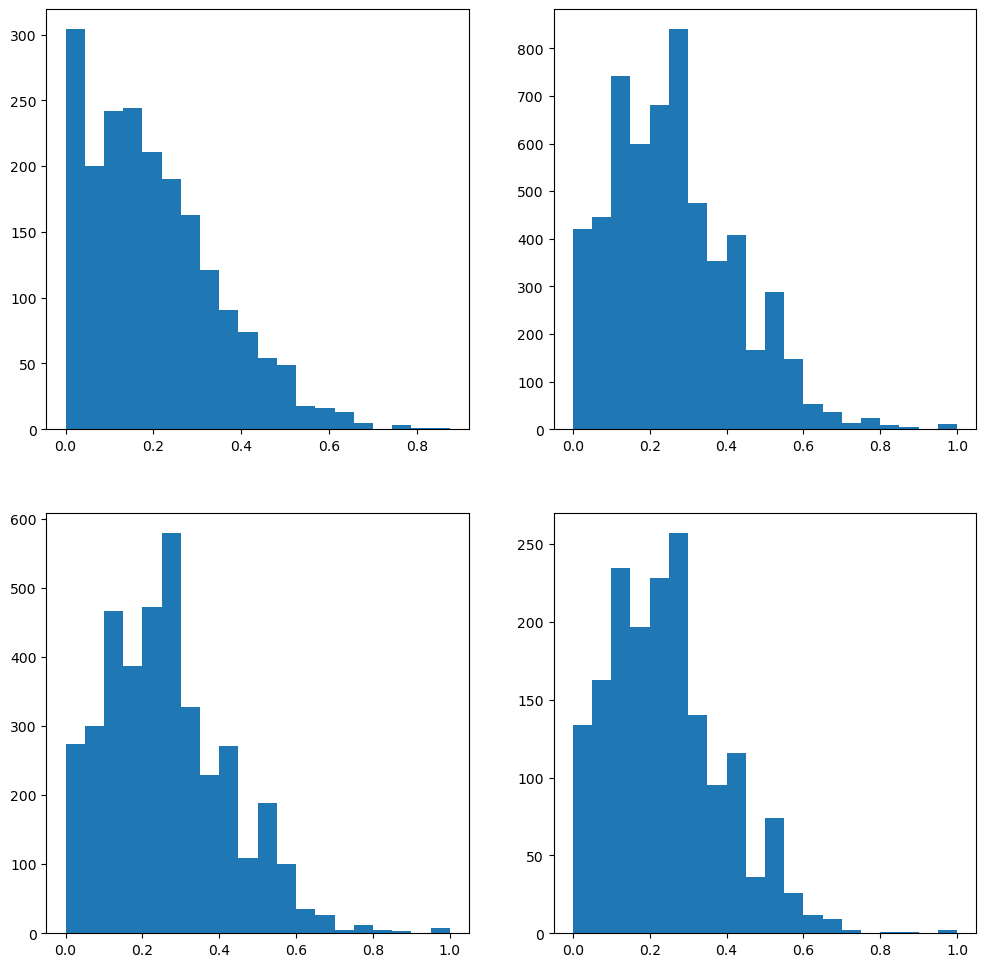

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0, 0].hist(movie_data[movie_data['year>=p0.25'] == 0]['female_ratio'], bins=20)
axs[0, 1].hist(movie_data[movie_data['year>=p0.25'] == 1]['female_ratio'], bins=20)
axs[1, 0].hist(movie_data[movie_data['year>=p0.5'] == 1]['female_ratio'], bins=20)
axs[1, 1].hist(movie_data[movie_data['year>=p0.75'] == 1]['female_ratio'], bins=20)

(array([2.000e+00, 1.000e+00, 3.000e+00, 1.500e+01, 5.500e+01, 4.900e+01,
        3.300e+01, 3.700e+01, 1.100e+02, 1.380e+02, 1.930e+02, 4.630e+02,
        7.390e+02, 7.060e+02, 5.640e+02, 8.670e+02, 1.014e+03, 1.109e+03,
        1.269e+03, 1.664e+03, 1.750e+03, 1.718e+03, 1.453e+03, 2.189e+03,
        2.595e+03, 3.530e+03, 4.778e+03, 7.165e+03, 9.173e+03, 2.139e+03]),
 array([  0.        ,   4.86666667,   9.73333333,  14.6       ,
         19.46666667,  24.33333333,  29.2       ,  34.06666667,
         38.93333333,  43.8       ,  48.66666667,  53.53333333,
         58.4       ,  63.26666667,  68.13333333,  73.        ,
         77.86666667,  82.73333333,  87.6       ,  92.46666667,
         97.33333333, 102.2       , 107.06666667, 111.93333333,
        116.8       , 121.66666667, 126.53333333, 131.4       ,
        136.26666667, 141.13333333, 146.        ]),
 <BarContainer object of 30 artists>)

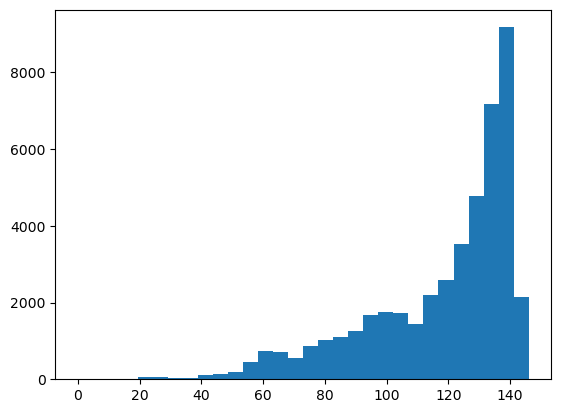

In [13]:
plt.hist(movie_data[feat_columns]['release_date'], bins=30)

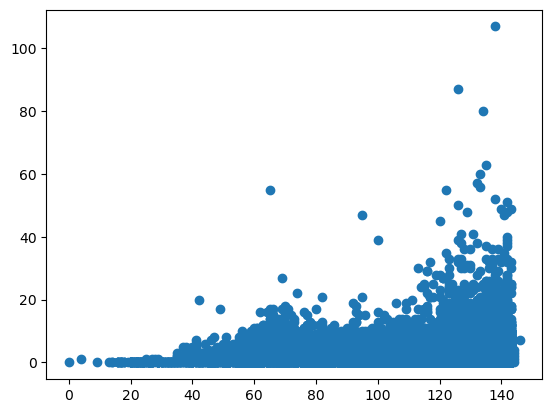

In [12]:
plt.scatter(movie_data[feat_columns]['release_date'], movie_data[feat_columns]['num_female'])

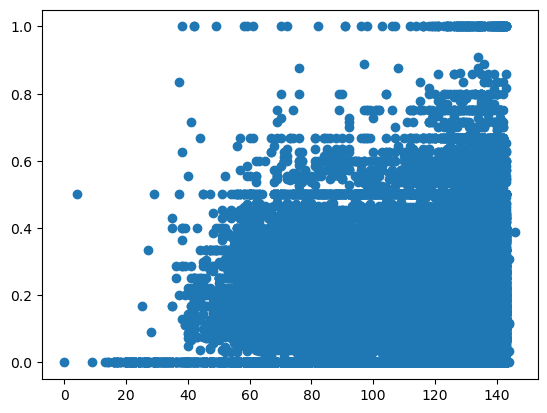

In [13]:
plt.scatter(movie_data[feat_columns]['release_date'], movie_data[feat_columns]['female_ratio'])

In [19]:
ast.literal_eval(movie_data[feat_columns]['crew'][0])

[{'credit_id': '52fe4284c3a36847f8024f49',
  'department': 'Directing',
  'gender': 2,
  'id': 7879,
  'job': 'Director',
  'name': 'John Lasseter',
  'profile_path': '/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f4f',
  'department': 'Writing',
  'gender': 2,
  'id': 12891,
  'job': 'Screenplay',
  'name': 'Joss Whedon',
  'profile_path': '/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f55',
  'department': 'Writing',
  'gender': 2,
  'id': 7,
  'job': 'Screenplay',
  'name': 'Andrew Stanton',
  'profile_path': '/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f5b',
  'department': 'Writing',
  'gender': 2,
  'id': 12892,
  'job': 'Screenplay',
  'name': 'Joel Cohen',
  'profile_path': '/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg'},
 {'credit_id': '52fe4284c3a36847f8024f61',
  'department': 'Writing',
  'gender': 0,
  'id': 12893,
  'job': 'Screenplay',
  'name': 'Alec Sokolow',
  'profile_path': '/v79vlRYi94BZUQnkkyzn

## Logistic Regression Part

In [38]:
### Data Loading ###

root = "data/"

# I'm the only one going to be using these so I didn't bother making it generalizable
# load
metadata = pd.read_csv(root + "MoviesDataset/movies_metadata.csv")
links = pd.read_csv(root + "MoviesDataset/links.csv")
bechedel_data = pd.read_json(root + "bechedeltest.json", orient='records')
credits = pd.read_csv("data/MoviesDataset/credits.csv")

# cleaning
movie_data = pd.merge(credits, metadata, on='id', how='inner')
movie_data = movie_data[~pd.isnull(movie_data['imdb_id'])]
movie_data['imdb_id'] = movie_data['imdb_id'].apply(lambda x: x[2:])

# add info about cast 
movie_data['num_female'] = movie_data['cast'].apply(lambda x:
    len([y for y in ast.literal_eval(x) if y['gender'] == 1]))
movie_data['num_characters'] = movie_data['cast'].apply(lambda x: len(ast.literal_eval(x)))
movie_data['female_ratio'] = movie_data['num_female'] / movie_data['num_characters']
movie_data['female_ratio'] = movie_data['female_ratio'].fillna(0)

# add bechedel data info
movie_data = pd.merge(movie_data, bechedel_data, left_on='imdb_id', right_on='imdbid', how='inner')

save_columns = [
    'genres', 'overview', 'popularity', 'release_date', 'revenue', 'runtime', 'vote_average',
    'vote_count', 'rating', 'num_female', 'female_ratio', 'title_x'
]
movie_data = movie_data[save_columns]

# dummy columns for genres
all_genres = {}
for idx, row in movie_data.iterrows():
    genres = ast.literal_eval(row['genres'])
    for x in genres:
        if x['name'] not in all_genres:
            all_genres[x['name']] = 0
        all_genres[x['name']] += 1
        
for genre in all_genres.keys():
    movie_data[genre] = movie_data['genres'].apply(lambda x: int(any([y['name'] == genre for y in ast.literal_eval(x)])))

# additional cleaning
# log revenue and vote_count since they're skewed
movie_data['revenue'] = movie_data['revenue'] / 10000
movie_data['revenue'][movie_data['revenue'] == 0] = movie_data['revenue'].mean()
movie_data['revenue'] = np.log(movie_data['revenue'])

movie_data['vote_count'][movie_data['vote_count'] == 0] = movie_data['vote_count'].mean()
movie_data['vote_count'] = np.log(movie_data['vote_count'])

# Release Date 
movie_data['release_date'] = movie_data['release_date'].apply(lambda x: int(x[:4]) if isinstance(x, str) else x)
num_na_releasedate = movie_data['release_date'].isna().sum()
movie_data['release_date'] = movie_data['release_date'].fillna(movie_data['release_date'].mean())
earliest_movie_releasedate = movie_data['release_date'].min()
movie_data['release_date'] = movie_data['release_date'] - movie_data['release_date'].min()

# split release date into percentile groups
# helps get around the horrible left skew in release date
movie_data['year>=p0.25'] = np.array(movie_data['release_date'] > movie_data['release_date'].quantile(0.25)).astype(int)
movie_data['year>=p0.5'] = np.array(movie_data['release_date'] > movie_data['release_date'].quantile(0.5)).astype(int)
movie_data['year>=p0.75'] = np.array(movie_data['release_date'] > movie_data['release_date'].quantile(0.75)).astype(int)

feat_columns = list(movie_data.columns)
feat_columns.remove('genres')
feat_columns.remove('overview')
feat_columns.remove('title_x')
feat_columns.remove('rating')
feat_columns.remove('release_date')

# labels
above0 = torch.from_numpy((movie_data['rating'] > 0).to_numpy()).int()
above1 = torch.from_numpy((movie_data['rating'] > 1).to_numpy()).int()
above2 = torch.from_numpy((movie_data['rating'] > 2).to_numpy()).int()
bechdel_labels = torch.vstack([above0, above1, above2]).T
bechdel_labels = bechdel_labels.float()
ratings = movie_data['rating'].to_numpy()

pd_bechdel_labels = pd.DataFrame(bechdel_labels, columns=["P>0", "P>1", "P>2"])

C:\Users\shirl\AppData\Local\Temp\ipykernel_76176\989755705.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['revenue'][movie_data['revenue'] == 0] = movie_data['revenue'].mean()
C:\Users\shirl\AppData\Local\Temp\ipykernel_76176\989755705.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['vote_count'][movie_data['vote_count'] == 0] = movie_data['vote_count'].mean()


(array([380.,   0.,   0., 464.,   0.,   0., 261.,   0.,   0., 895.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

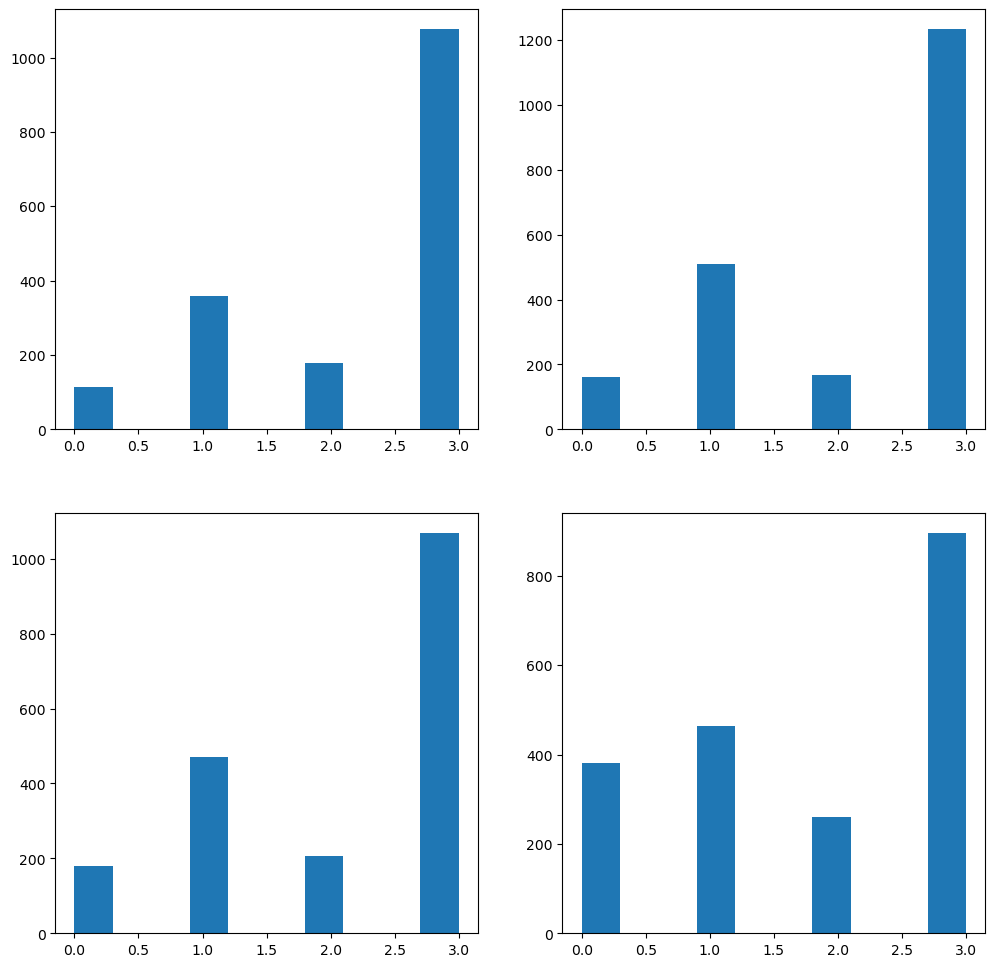

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0, 0].hist(movie_data[(movie_data['year>=p0.75'] == 1)]['rating'])
axs[0, 1].hist(movie_data[(movie_data['year>=p0.5'] == 1) & (movie_data['year>=p0.75'] == 0)]['rating'])
axs[1, 0].hist(movie_data[(movie_data['year>=p0.25'] == 1) & (movie_data['year>=p0.5'] == 0)]['rating'])
axs[1, 1].hist(movie_data[(movie_data['year>=p0.25'] == 0)]['rating'])

(array([  1.,   0.,   0.,   0.,   0.,   2.,   3.,   6.,   2.,   3.,  19.,
         25.,  28.,  32.,  30.,  35.,  28.,  28.,  50.,  40.,  57.,  49.,
         42.,  41.,  60.,  52.,  52.,  84.,  95., 114., 117., 141., 201.,
        232., 294., 380., 463., 586., 612., 268.]),
 array([ 25.   ,  27.975,  30.95 ,  33.925,  36.9  ,  39.875,  42.85 ,
         45.825,  48.8  ,  51.775,  54.75 ,  57.725,  60.7  ,  63.675,
         66.65 ,  69.625,  72.6  ,  75.575,  78.55 ,  81.525,  84.5  ,
         87.475,  90.45 ,  93.425,  96.4  ,  99.375, 102.35 , 105.325,
        108.3  , 111.275, 114.25 , 117.225, 120.2  , 123.175, 126.15 ,
        129.125, 132.1  , 135.075, 138.05 , 141.025, 144.   ]),
 <BarContainer object of 40 artists>)

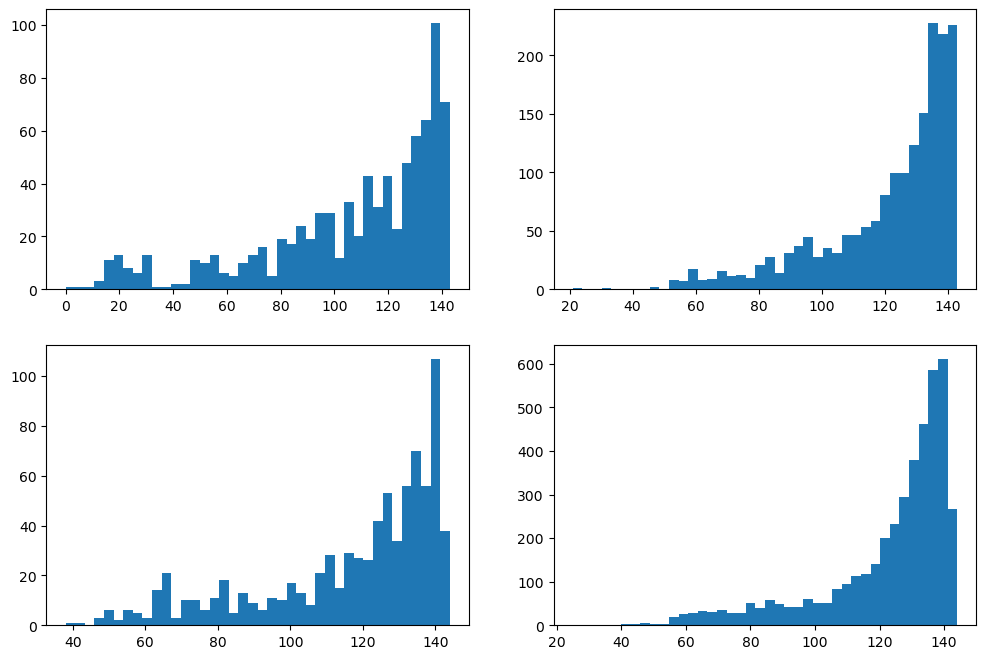

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].hist(movie_data[movie_data['rating'] == 0]['release_date'], bins=40)
axs[0, 1].hist(movie_data[movie_data['rating'] == 1]['release_date'], bins=40)
axs[1, 0].hist(movie_data[movie_data['rating'] == 2]['release_date'], bins=40)
axs[1, 1].hist(movie_data[movie_data['rating'] == 3]['release_date'], bins=40)

Text(0.5, 1.0, 'Release Date - 1874')

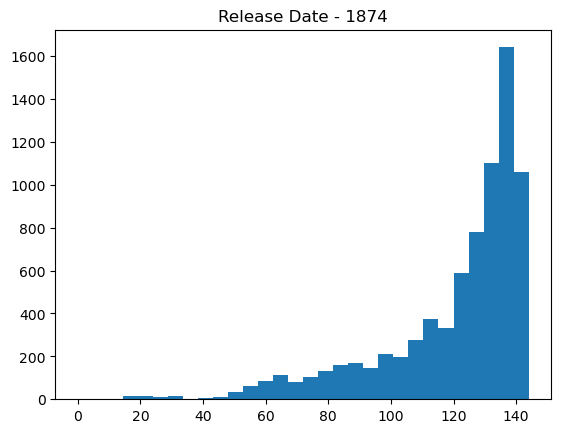

In [223]:
plt.hist(movie_data['release_date'], bins=30)
plt.title("Release Date - 1874")

Text(0.5, 1.0, 'Movie Release Date vs Bechdel Rating')

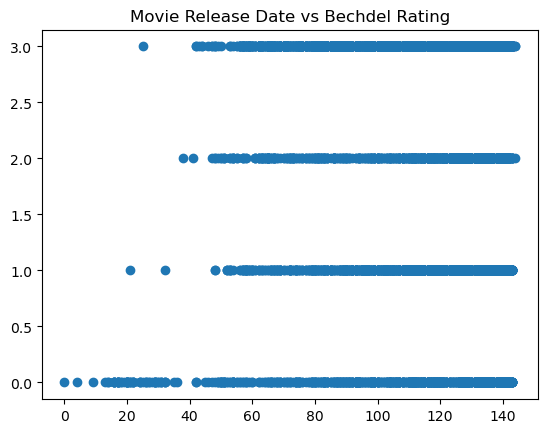

In [225]:
plt.scatter(movie_data['release_date'], movie_data['rating'])
plt.title("Movie Release Date vs Bechdel Rating")

In [4]:
def model_accuracy(model1, model2, model3, testdata, gt_labels):
    """
    Statsmodels makes me do one model per output
    """
    pred1 = (model1.predict(testdata) > 0.5).to_numpy().astype(int)
    pred2 = (model2.predict(testdata) > 0.5).to_numpy().astype(int)
    pred3 = (model3.predict(testdata) > 0.5).to_numpy().astype(int)
    
    # only go to the next level if it meets the previous level
    preds = pred1 
    preds[preds == 1] = preds[preds == 1] + pred2[preds == 1]
    preds[preds == 2] = preds[preds == 2] + pred3[preds == 2]
    #preds = pred1 + pred2 + pred3
    
    accuracy = (preds == gt_labels).astype(int).sum() / len(gt_labels)
    return accuracy, preds

def ensemble_prediction(models_list, testdata):
    preds = np.zeros(len(ratings))
    for model in models_list:
        out = model.predict(testdata)
        preds = preds + (out.to_numpy() > 0.5).astype(int)
    preds = preds / len(models_list)
    return preds

def model_ens_accuracy(model1, model2, model3, testdata, gt_labels):
    """
    Statsmodels makes me do one model per output
    """
    pred1 = (model1.predict(testdata) > 0.5).to_numpy().astype(int)
    pred2 = (ensemble_prediction(model2, testdata) > 0.5).astype(int)
    pred3 = (ensemble_prediction(model3, testdata) > 0.5).astype(int)
    
    # only go to the next level if it meets the previous level
    preds = pred1 
    preds[preds == 1] = preds[preds == 1] + pred2[preds == 1]
    preds[preds == 2] = preds[preds == 2] + pred3[preds == 2]
    #preds = pred1 + pred2 + pred3
    
    accuracy = (preds == gt_labels).astype(int).sum() / len(gt_labels)
    return accuracy, preds

In [60]:
### Predict if bechdel rating > 0 ###

log_reg1 = sm.Logit(pd_bechdel_labels['P>0'], movie_data[feat_columns]).fit()

acc = (pd_bechdel_labels["P>0"] == (log_reg1.predict(movie_data[feat_columns]) > 0.5).astype(int)).sum() / len(movie_data)
print("Accuracy", acc)

Optimization terminated successfully.
         Current function value: 0.247476
         Iterations 9
Accuracy 0.9046879046879047


In [61]:
### K-fold ensemble for if bechdel rating > 1 and > 2 ###

k_folds = 10
partition = (len(movie_data) // k_folds) + 1
indices = np.arange(0, len(movie_data))
np.random.shuffle(indices)

model2s = []
model3s = []

for curr_k in range(k_folds):
    print("Fold", curr_k)

    val_indices = indices[partition*curr_k : partition*(curr_k+1)]
    mask = np.ones(len(movie_data), dtype=bool)
    mask[val_indices] = False
    train_indices = indices[mask]
    
    log_reg2 = sm.Logit(pd_bechdel_labels['P>1'][train_indices], movie_data.loc[train_indices, feat_columns]).fit()
    log_reg3 = sm.Logit(pd_bechdel_labels['P>2'][train_indices], movie_data.loc[train_indices, feat_columns]).fit()
    
    train_acc, _ = model_accuracy(log_reg1, log_reg2, log_reg3, movie_data.loc[train_indices, feat_columns], 
                               ratings[train_indices])
    val_acc, _ = model_accuracy(log_reg1, log_reg2, log_reg3, movie_data.loc[val_indices, feat_columns], ratings[val_indices])
    print("Train Accuracy:", train_acc, "Val Accuracy:", val_acc)
    
    model2s.append(log_reg2)
    model3s.append(log_reg3)

Fold 0
Optimization terminated successfully.
         Current function value: 0.533676
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.584988
         Iterations 6
Train Accuracy: 0.5354727298891927 Val Accuracy: 0.5446313065976714
Fold 1
Optimization terminated successfully.
         Current function value: 0.531503
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.584080
         Iterations 6
Train Accuracy: 0.5454022161462081 Val Accuracy: 0.51875808538163
Fold 2
Optimization terminated successfully.
         Current function value: 0.527359
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.581996
         Iterations 6
Train Accuracy: 0.5482803281047632 Val Accuracy: 0.5510996119016818
Fold 3
Optimization terminated successfully.
         Current function value: 0.533896
         Iterations 6
Optimization terminated successfully.
         Current f

In [62]:
ens_acc, ens_preds = model_ens_accuracy(log_reg1, model2s, model3s, movie_data[feat_columns], ratings)
ens_acc

0.5418285418285418

In [63]:
log_reg1 = sm.Logit(pd_bechdel_labels['P>0'], movie_data[feat_columns]).fit()
log_reg2 = sm.Logit(pd_bechdel_labels['P>1'], movie_data[feat_columns]).fit()
log_reg3 = sm.Logit(pd_bechdel_labels['P>2'], movie_data[feat_columns]).fit()

acc, preds = model_accuracy(log_reg1, log_reg2, log_reg3, movie_data[feat_columns], ratings)
acc

Optimization terminated successfully.
         Current function value: 0.247476
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.532207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.585199
         Iterations 6


0.5415695415695416

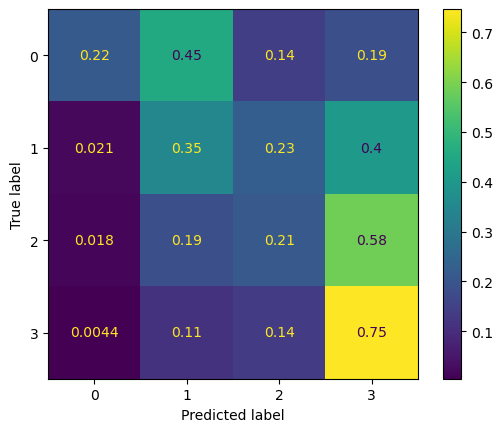

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    ratings, preds, labels=[0, 1, 2, 3], normalize='true'
)

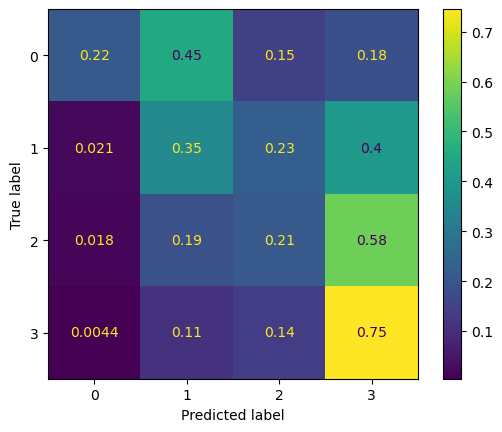

In [73]:
ConfusionMatrixDisplay.from_predictions(
    ratings, ens_preds, labels=[0, 1, 2, 3], normalize='true'
)

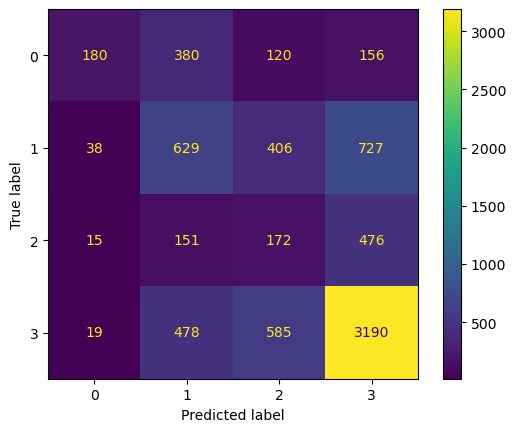

In [74]:
ConfusionMatrixDisplay.from_predictions(
    ratings, preds, labels=[0, 1, 2, 3]
)

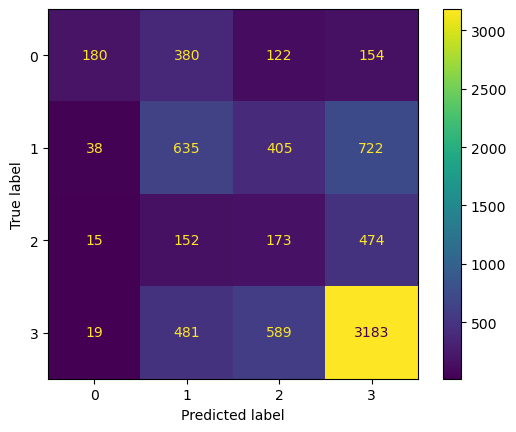

In [75]:
ConfusionMatrixDisplay.from_predictions(
    ratings, ens_preds, labels=[0, 1, 2, 3]
)

## Logistic Increasing

Only train model on data that meets the previous requirements.

In [40]:
log_reg1 = sm.Logit(pd_bechdel_labels['P>0'], sm.add_constant(movie_data[feat_columns])).fit()
log_reg2 = sm.Logit(pd_bechdel_labels[pd_bechdel_labels['P>0'] == 1]['P>1'], 
                    sm.add_constant(movie_data[movie_data['rating'] > 0][feat_columns])).fit()
log_reg3 = sm.Logit(pd_bechdel_labels[pd_bechdel_labels['P>1'] == 1]['P>2'], 
                    sm.add_constant(movie_data[movie_data['rating'] > 1][feat_columns])).fit()

acc, preds = model_accuracy(log_reg1, log_reg2, log_reg3, sm.add_constant(movie_data[feat_columns]), ratings)
acc

Optimization terminated successfully.
         Current function value: 0.247469
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.504243
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.411554
         Iterations 8


0.5951825951825952

In [41]:
((log_reg1.predict(sm.add_constant(movie_data[feat_columns])) > 0.5) == (movie_data['rating'] > 0)).sum() / len(movie_data)

0.9058534058534059

In [42]:
((log_reg2.predict(sm.add_constant(movie_data[movie_data['rating'] > 0][feat_columns])) > 0.5) == \
 (movie_data[movie_data['rating'] > 0]['rating'] > 1)).sum() / len(movie_data)

0.671976171976172

In [43]:
((log_reg2.predict(sm.add_constant(movie_data[movie_data['rating'] > 1][feat_columns])) > 0.5) == \
 (movie_data[movie_data['rating'] > 1]['rating'] > 2)).sum() / len(movie_data)

0.534965034965035

In [137]:
pred1 = (movie_data['rating'] > 0).to_numpy().astype(int)
pred2 = (log_reg2.predict(movie_data[feat_columns]) > 0.5).to_numpy().astype(int)
pred3 = (log_reg3.predict(movie_data[feat_columns]) > 0.5).to_numpy().astype(int)

# only go to the next level if it meets the previous level
preds = pred1 
preds[preds == 1] = preds[preds == 1] + pred2[preds == 1]
preds[preds == 2] = preds[preds == 2] + pred3[preds == 2]
#preds = pred1 + pred2 + pred3

accuracy = (preds == movie_data['rating']).astype(int).sum() / len(movie_data['rating'])
accuracy, preds

(0.684019684019684, array([3, 3, 3, ..., 0, 0, 3]))

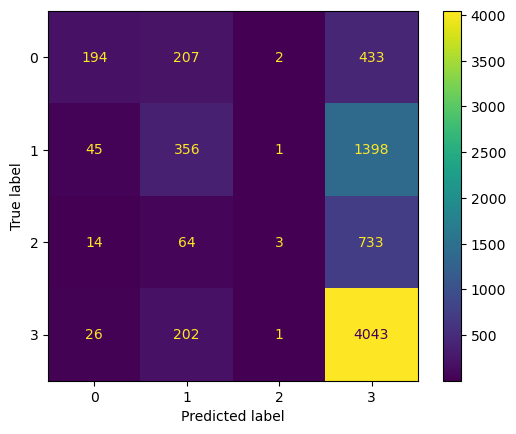

In [45]:
ConfusionMatrixDisplay.from_predictions(
    ratings, preds, labels=[0, 1, 2, 3]
)

In [1]:
ConfusionMatrixDisplay.from_predictions(
    ratings, preds, labels=[0, 1, 2, 3], normalize='true'
)

plt.savefig("part2_classmatrix.png")

NameError: name 'ConfusionMatrixDisplay' is not defined

In [17]:
log_reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    P>2   No. Observations:                 5086
Model:                          Logit   Df Residuals:                     5053
Method:                           MLE   Df Model:                           32
Date:                Mon, 28 Nov 2022   Pseudo R-squ.:                 0.06670
Time:                        00:36:01   Log-Likelihood:                -2087.4
converged:                       True   LL-Null:                       -2236.6
Covariance Type:            nonrobust   LLR p-value:                 5.620e-45
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.7375      0.402      1.835      0.067      -0.050       1.525
popularity          0.0095      0.007      1.436      0.151      -0.003       0.022
revenue             0.0172      0.023      0.733      0.463      -0.029       0.063
runtime            -0.0017      0.002     -0.894      0.372      -0.005       0.002
vote_average        0.0363      0.049      0.742      0.458      -0.060       0.132
vote_count         -0.1497      0.034     -4.428      0.000      -0.216      -0.083
num_female          0.0122      0.012      1.050      0.294      -0.011       0.035
female_ratio        2.6826      0.334      8.031      0.000       2.028       3.337
Animation          -0.1371      0.214     -0.640      0.522      -0.557       0.283
Comedy             -0.2863      0.097     -2.939      0.003      -0.477      -0.095
Family              0.6622      0.197      3.357      0.001       0.276       1.049
Adventure           0.0428      0.144      0.298      0.766      -0.239       0.325
Fantasy            -0.0478      0.147     -0.326      0.745      -0.335       0.240
Drama               0.0400      0.102      0.392      0.695      -0.160       0.240
Romance            -0.2785      0.097     -2.859      0.004      -0.470      -0.088
Action             -0.2292      0.126     -1.823      0.068      -0.476       0.017
Crime              -0.1840      0.137     -1.339      0.181      -0.453       0.085
Thriller           -0.0411      0.117     -0.350      0.726      -0.271       0.189
Horror              0.2458      0.145      1.690      0.091      -0.039       0.531
Science Fiction    -0.1142      0.140     -0.816      0.414      -0.388       0.160
Mystery             0.2974      0.175      1.698      0.090      -0.046       0.641
History            -0.4763      0.201     -2.370      0.018      -0.870      -0.082
Music               0.2830      0.200      1.414      0.157      -0.109       0.675
War                -0.0143      0.265     -0.054      0.957      -0.534       0.505
Western            -0.8517      0.306     -2.782      0.005      -1.452      -0.252
Documentary         1.8893      1.025      1.843      0.065      -0.120       3.899
Foreign             1.3016      0.731      1.780      0.075      -0.131       2.734
TV Movie            0.3610      0.606      0.596      0.551      -0.826       1.548
year>=p0.1          0.5173      0.152      3.402      0.001       0.219       0.815
year>=p0.25         0.2257      0.130      1.733      0.083      -0.030       0.481
year>=p0.5          0.2779      0.116      2.403      0.016       0.051       0.505
year>=p0.75        -0.0386      0.137     -0.281      0.779      -0.308       0.231
year>=p0.9          0.0287      0.170      0.169      0.866      -0.305       0.362
===================================================================================
"""

In [47]:
def get_info_from_summary(info_table):
    sig_coefs = {}
    sig_intervals = {}
    unsig_coefs = {}
    unsig_intervals = {}
    for i in range(1, len(info_table)):
        if float(info_table[i][4]) < 0.05:
            sig_coefs[info_table[i][0]] = float(info_table[i][1])
            sig_intervals[info_table[i][0]] = (float(info_table[i][5]), float(info_table[i][6]))
        else:
            unsig_coefs[info_table[i][0]] = float(info_table[i][1])
            unsig_intervals[info_table[i][0]] = (float(info_table[i][5]), float(info_table[i][6]))
            
    return sig_coefs, sig_intervals, unsig_coefs, unsig_intervals

sig_coefs1, sig_intervals1, unsig_coefs1, unsig_intervals1 = get_info_from_summary(log_reg1.summary().tables[1].data)
sig_coefs2, sig_intervals2, unsig_coefs2, unsig_intervals2 = get_info_from_summary(log_reg2.summary().tables[1].data)
sig_coefs3, sig_intervals3, unsig_coefs3, unsig_intervals3 = get_info_from_summary(log_reg3.summary().tables[1].data)

In [56]:
genres_key = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 
              'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 
              'Romance', 'Science Fiction', 'Thriller', 'TV Movie', 'War', 'Western'
             ]
years_key = ['year>=p0.25', 'year>=p0.5', 'year>=p0.75']
others_key = ['runtime', 'vote_average', 'vote_count',
              'popularity', 'revenue',  'num_female', #'female_ratio',
             ]

genres_key = {genres_key[i]: len(genres_key)-i for i in range(len(genres_key))}
years_key = {years_key[i]: len(years_key)-i for i in range(len(years_key))}
others_key = {others_key[i]: len(others_key)-i for i in range(len(others_key))}

In [49]:
def coefplot(coefs, intervals, labeldata, ax, label, bold=True, color='blue'):
    if bold:
        capsize=5
        lw=3
        s=40
    else:
        capsize=4
        lw=1
        s=20
    
    widths = (np.array(list(intervals.values())).T - np.array(list(coefs.values())))
    widths[0] = widths[0] * -1
    
    ax.errorbar(list(coefs.values()), labeldata, capsize=capsize,
                xerr=widths, linewidth=0, elinewidth=lw, label=label, color=color)

    ax.axvline(x=0, c='red', linestyle='--')
    ax.scatter(y=labeldata, marker='o', s=s, x=list(coefs.values()), color=color)
    
def subset_plotdata(coefs_dict, intervals_dict, plottype='genre'):
    if plottype == 'genre':
        use_key = genres_key
    elif plottype == 'year':
        use_key = years_key
    else:
        use_key = others_key
        
    labels = [use_key[x] for x in coefs_dict if x in use_key]
    coefs = {k : v for k, v in coefs_dict.items() if k in use_key}
    intervals = {k : v for k, v in intervals_dict.items() if k in use_key}
    
    return labels, coefs, intervals

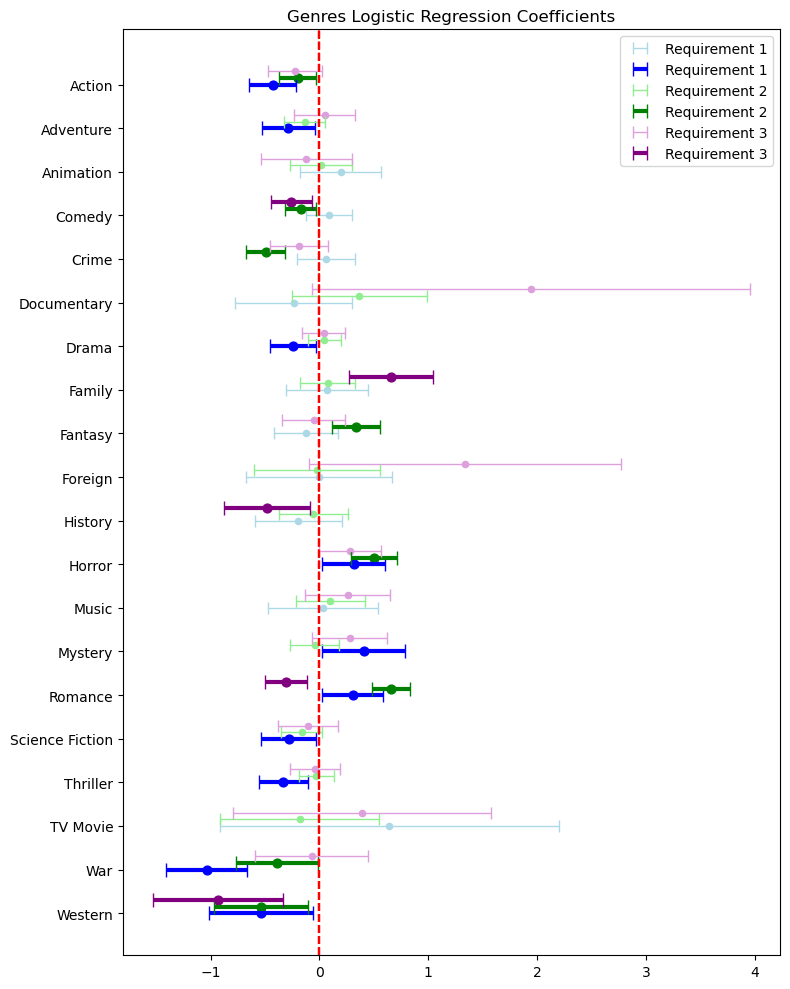

In [50]:
fig, axs = plt.subplots(figsize=(8, 10))

labels, coefs, intervals = subset_plotdata(unsig_coefs1, unsig_intervals1, plottype='genre')
coefplot(coefs, intervals, labels, axs, "Requirement 1", bold=False, color='lightblue')

labels, coefs, intervals = subset_plotdata(sig_coefs1, sig_intervals1, plottype='genre')
coefplot(coefs, intervals, labels, axs, "Requirement 1", bold=True, color='blue')

labels, coefs, intervals = subset_plotdata(unsig_coefs2, unsig_intervals2, plottype='genre')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs, "Requirement 2", bold=False, color='lightgreen')

labels, coefs, intervals = subset_plotdata(sig_coefs2, sig_intervals2, plottype='genre')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs, "Requirement 2", bold=True, color='green')

labels, coefs, intervals = subset_plotdata(unsig_coefs3, unsig_intervals3, plottype='genre')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs, "Requirement 3", bold=False, color='plum')

labels, coefs, intervals = subset_plotdata(sig_coefs3, sig_intervals3, plottype='genre')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs, "Requirement 3", bold=True, color='purple')

axs.set_yticks(list(genres_key.values()))
axs.set_yticklabels(list(genres_key.keys()))
axs.legend()

axs.set_title("Genres Logistic Regression Coefficients")
plt.tight_layout()
fig.savefig("coefficients.png")
plt.show()

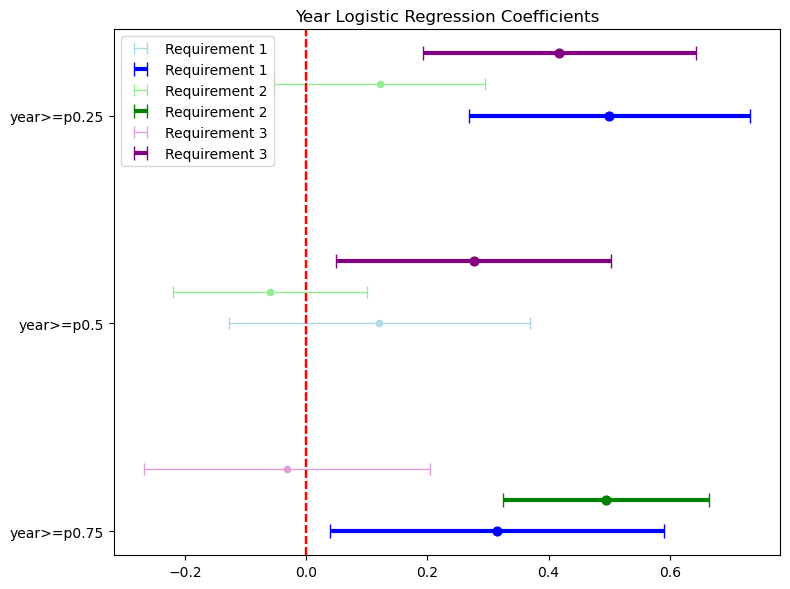

In [58]:
fig, axs = plt.subplots(figsize=(8, 6))

labels, coefs, intervals = subset_plotdata(unsig_coefs1, unsig_intervals1, plottype='year')
coefplot(coefs, intervals, labels, axs, "Requirement 1", bold=False, color='lightblue')

labels, coefs, intervals = subset_plotdata(sig_coefs1, sig_intervals1, plottype='year')
coefplot(coefs, intervals, labels, axs, "Requirement 1", bold=True, color='blue')

labels, coefs, intervals = subset_plotdata(unsig_coefs2, unsig_intervals2, plottype='year')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs, "Requirement 2", bold=False, color='lightgreen')

labels, coefs, intervals = subset_plotdata(sig_coefs2, sig_intervals2, plottype='year')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs, "Requirement 2", bold=True, color='green')

labels, coefs, intervals = subset_plotdata(unsig_coefs3, unsig_intervals3, plottype='year')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs, "Requirement 3", bold=False, color='plum')

labels, coefs, intervals = subset_plotdata(sig_coefs3, sig_intervals3, plottype='year')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs, "Requirement 3", bold=True, color='purple')

axs.set_yticks(list(years_key.values()))
axs.set_yticklabels(list(years_key.keys()))
axs.legend()

axs.set_title("Year Logistic Regression Coefficients")
plt.tight_layout()
fig.savefig("year_coefs.png")
plt.show()

In [55]:
movie_data['release_date'].quantile(0.75) + earliest_movie_releasedate

2011.0

In [154]:
print(movie_data['release_date'].quantile(0.1) + earliest_movie_releasedate)
print(movie_data['release_date'].quantile(0.25) + earliest_movie_releasedate)
print(movie_data['release_date'].quantile(0.5) + earliest_movie_releasedate)
print(movie_data['release_date'].quantile(0.75) + earliest_movie_releasedate)
print(movie_data['release_date'].quantile(0.9) + earliest_movie_releasedate)

1958.0
1986.0
2003.0
2011.0
2014.0


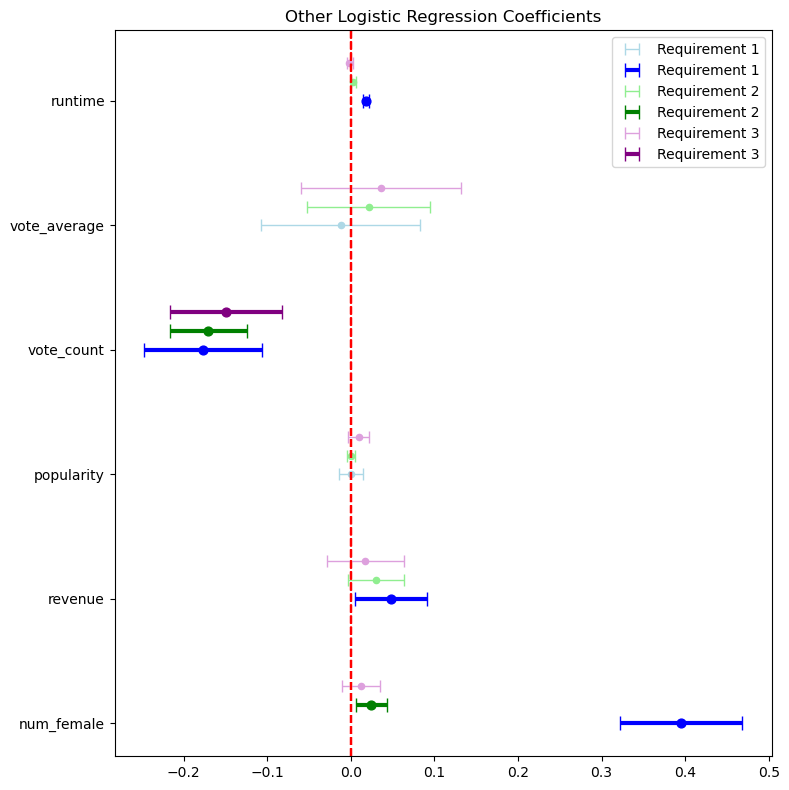

In [24]:
fig, axs = plt.subplots(figsize=(8, 8))

labels, coefs, intervals = subset_plotdata(unsig_coefs1, unsig_intervals1, plottype='other')
coefplot(coefs, intervals, labels, axs, "Requirement 1", bold=False, color='lightblue')

labels, coefs, intervals = subset_plotdata(sig_coefs1, sig_intervals1, plottype='other')
coefplot(coefs, intervals, labels, axs, "Requirement 1", bold=True, color='blue')

labels, coefs, intervals = subset_plotdata(unsig_coefs2, unsig_intervals2, plottype='other')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs, "Requirement 2", bold=False, color='lightgreen')

labels, coefs, intervals = subset_plotdata(sig_coefs2, sig_intervals2, plottype='other')
labels = np.array(labels) + 0.15
coefplot(coefs, intervals, labels, axs, "Requirement 2", bold=True, color='green')

labels, coefs, intervals = subset_plotdata(unsig_coefs3, unsig_intervals3, plottype='other')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs, "Requirement 3", bold=False, color='plum')

labels, coefs, intervals = subset_plotdata(sig_coefs3, sig_intervals3, plottype='other')
labels = np.array(labels) + 0.3
coefplot(coefs, intervals, labels, axs, "Requirement 3", bold=True, color='purple')

axs.set_yticks(list(others_key.values()))
axs.set_yticklabels(list(others_key.keys()))
axs.legend()

axs.set_title("Other Logistic Regression Coefficients")
plt.tight_layout()
fig.savefig("other_coefs.png")
plt.show()

(array([3.100e+01, 1.100e+01, 8.100e+01, 1.795e+03, 3.420e+03, 1.182e+03,
        2.420e+02, 7.000e+01, 3.100e+01, 6.000e+00, 6.000e+00, 2.000e+00,
        3.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0. ,  23.5,  47. ,  70.5,  94. , 117.5, 141. , 164.5, 188. ,
        211.5, 235. , 258.5, 282. , 305.5, 329. , 352.5, 376. , 399.5,
        423. , 446.5, 470. , 493.5, 517. , 540.5, 564. , 587.5, 611. ,
        634.5, 658. , 681.5, 705. ]),
 <BarContainer object of 30 artists>)

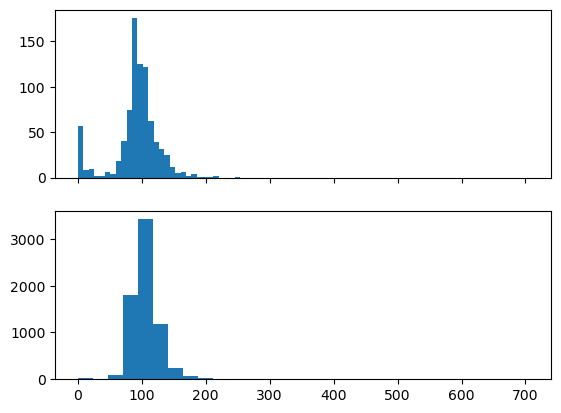

In [201]:
fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].hist(movie_data[movie_data['rating'] == 0]['runtime'], bins=30)
axs[1].hist(movie_data[movie_data['rating'] > 0]['runtime'], bins=30)

In [82]:
log_reg2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    P>1   No. Observations:                 6886
Model:                          Logit   Df Residuals:                     6858
Method:                           MLE   Df Model:                           27
Date:                Mon, 21 Nov 2022   Pseudo R-squ.:                  0.1178
Time:                        23:02:47   Log-Likelihood:                -3490.0
converged:                       True   LL-Null:                       -3956.1
Covariance Type:            nonrobust   LLR p-value:                4.911e-179
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
popularity          0.0020      0.003      0.773      0.439      -0.003       0.007
release_date        0.0043      0.001      3.429      0.001       0.002       0.007
revenue             0.0187      0.016      1.180      0.238      -0.012       0.050
runtime             0.0018      0.001      1.259      0.208      -0.001       0.004
vote_average       -0.0128      0.028     -0.459      0.646      -0.067       0.042
vote_count         -0.1654      0.023     -7.264      0.000      -0.210      -0.121
num_female          0.0312      0.010      3.249      0.001       0.012       0.050
female_ratio        4.2508      0.268     15.859      0.000       3.725       4.776
Animation           0.0232      0.144      0.161      0.872      -0.259       0.305
Comedy             -0.2053      0.073     -2.818      0.005      -0.348      -0.063
Family              0.0341      0.129      0.265      0.791      -0.218       0.286
Adventure          -0.1496      0.096     -1.565      0.118      -0.337       0.038
Fantasy             0.3162      0.113      2.804      0.005       0.095       0.537
Drama               0.0423      0.076      0.556      0.578      -0.107       0.191
Romance             0.6336      0.089      7.082      0.000       0.458       0.809
Action             -0.2244      0.086     -2.614      0.009      -0.393      -0.056
Crime              -0.5192      0.090     -5.761      0.000      -0.696      -0.343
Thriller           -0.0484      0.082     -0.590      0.555      -0.209       0.112
Horror              0.4453      0.104      4.265      0.000       0.241       0.650
Science Fiction    -0.1857      0.096     -1.929      0.054      -0.374       0.003
Mystery            -0.0745      0.115     -0.649      0.516      -0.299       0.150
History            -0.0466      0.160     -0.292      0.771      -0.360       0.267
Music               0.1015      0.161      0.629      0.529      -0.215       0.418
War                -0.3911      0.191     -2.050      0.040      -0.765      -0.017
Western            -0.5648      0.217     -2.601      0.009      -0.990      -0.139
Documentary         0.3558      0.314      1.132      0.258      -0.260       0.972
Foreign            -0.1407      0.294     -0.479      0.632      -0.717       0.435
TV Movie           -0.1605      0.368     -0.436      0.663      -0.882       0.561
===================================================================================
"""

(array([ 31.,   0.,  40.,  52.,  39., 109., 163., 148., 219., 252., 291.,
        278., 288., 331., 325., 307., 308., 288., 305., 268., 233., 208.,
        165., 144., 102.,  82.,  56.,  36.,  14.,   4.]),
 array([0.        , 0.31840518, 0.63681036, 0.95521555, 1.27362073,
        1.59202591, 1.91043109, 2.22883627, 2.54724145, 2.86564664,
        3.18405182, 3.502457  , 3.82086218, 4.13926736, 4.45767254,
        4.77607773, 5.09448291, 5.41288809, 5.73129327, 6.04969845,
        6.36810364, 6.68650882, 7.004914  , 7.32331918, 7.64172436,
        7.96012954, 8.27853473, 8.59693991, 8.91534509, 9.23375027,
        9.55215545]),
 <BarContainer object of 30 artists>)

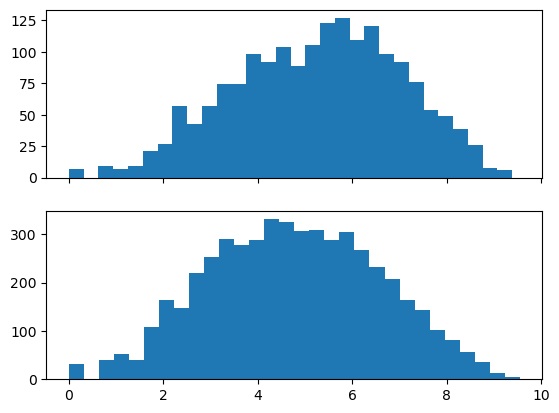

In [84]:
fig, axs = plt.subplots(2, 1, sharex=True)

axs[0].hist(movie_data[movie_data['rating'] == 1]['vote_count'], bins=30)
axs[1].hist(movie_data[movie_data['rating'] > 1]['vote_count'], bins=30)

In [99]:
genre = "Comedy"
movie_data[movie_data[genre] == 1]['rating'].value_counts() / len(movie_data[movie_data[genre] == 1]['rating'])

3    0.582900
1    0.225651
2    0.117844
0    0.073606
Name: rating, dtype: float64

In [100]:
movie_data[movie_data[genre] != 1]['rating'].value_counts() / len(movie_data[movie_data[genre] != 1]['rating'])

3    0.537361
1    0.237083
0    0.126789
2    0.098768
Name: rating, dtype: float64

(array([ 59., 170., 473., 691., 801., 752., 657., 426., 196.,  47.]),
 array([0.        , 0.95521555, 1.91043109, 2.86564664, 3.82086218,
        4.77607773, 5.73129327, 6.68650882, 7.64172436, 8.59693991,
        9.55215545]),
 <BarContainer object of 10 artists>)

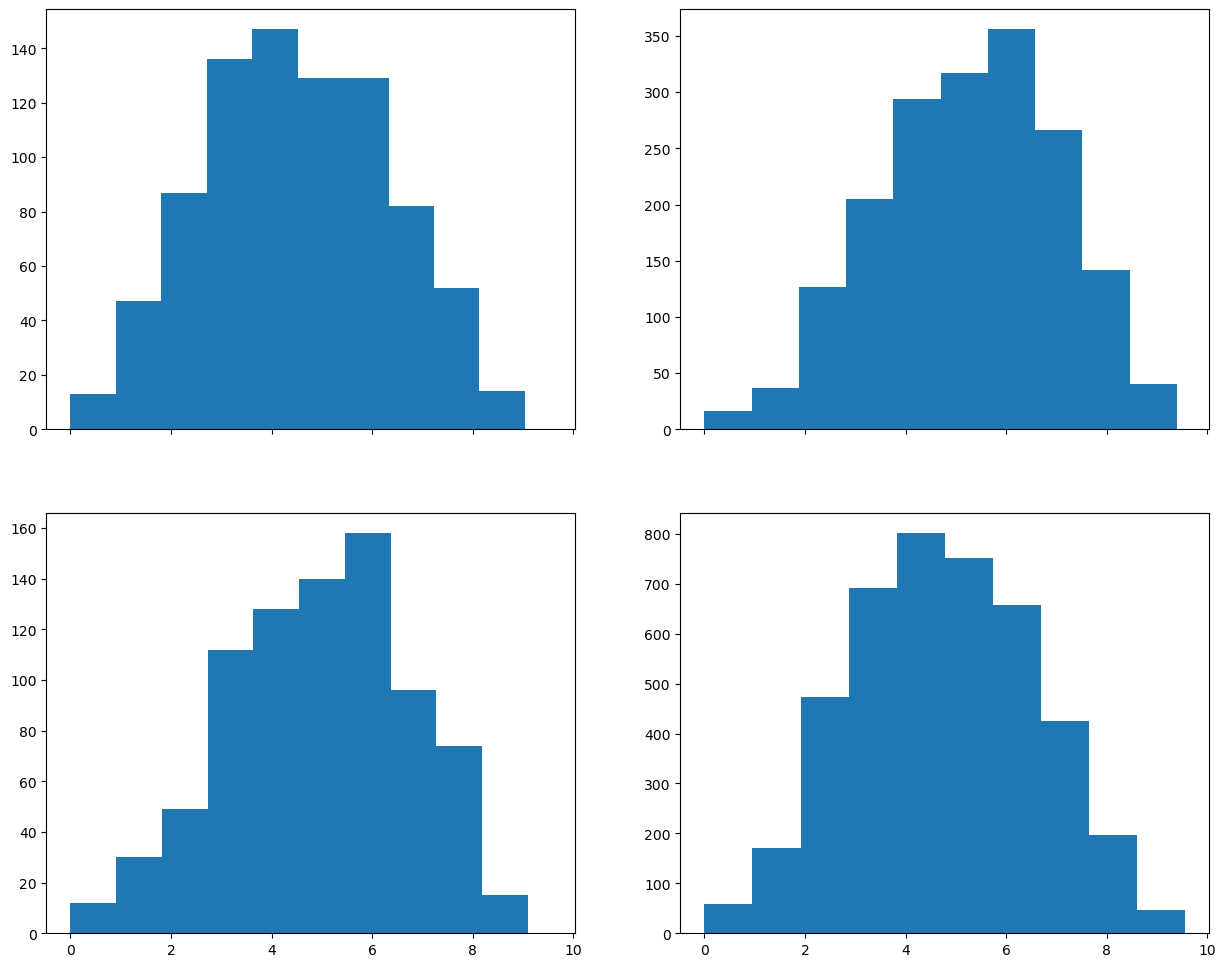

In [202]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12), sharex=True)
axs[0,0].hist(movie_data[movie_data['rating'] == 0]['vote_count'])
axs[0,1].hist(movie_data[movie_data['rating'] == 1]['vote_count'])
axs[1,0].hist(movie_data[movie_data['rating'] == 2]['vote_count'])
axs[1,1].hist(movie_data[movie_data['rating'] == 3]['vote_count'])

In [203]:
movie_data[movie_data['rating'] == 0]['vote_count'].mean()

4.517955054487219

In [204]:
movie_data[movie_data['rating'] == 1]['vote_count'].mean()

5.251194536631672

In [205]:
movie_data[movie_data['rating'] == 2]['vote_count'].mean()

4.952364980483232

In [206]:
movie_data[movie_data['rating'] == 3]['vote_count'].mean()

4.732716303565408

## Ordinal Regression

Try this one might as well.

Accuracy better but actually no.

In [137]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [138]:
movie_data['ordered_rating'] = pd.Categorical(movie_data['rating'], categories=[0, 1, 2, 3], ordered=True)

In [154]:
mod_prob = OrderedModel(movie_data['ordered_rating'], movie_data[feat_columns], distr='probit').fit(method='bfgs')

mod_prob.summary()

Optimization terminated successfully.
         Current function value: 1.008462
         Iterations: 100
         Function evaluations: 104
         Gradient evaluations: 104


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:         ordered_rating   Log-Likelihood:                -7787.3
Model:                   OrderedModel   AIC:                         1.564e+04
Method:            Maximum Likelihood   BIC:                         1.585e+04
Date:                Mon, 21 Nov 2022                                         
Time:                        22:02:28                                         
No. Observations:                7722                                         
Df Residuals:                    7691                                         
Df Model:                          31                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
popularity         -0.0009      0.001     -0.670      0.503      -0.004       0.002
release_date        0.0063      0.001      9.861      0.000       0.005       0.008
revenue             0.0051      0.002      3.080      0.002       0.002       0.008
runtime             0.0045      0.001      7.064      0.000       0.003       0.006
vote_average       -0.0315      0.017     -1.869      0.062      -0.065       0.002
vote_count         -0.0052      0.002     -2.425      0.015      -0.009      -0.001
num_female          0.0149      0.004      3.857      0.000       0.007       0.022
female_ratio        3.1045      0.119     26.118      0.000       2.872       3.337
Animation          -0.0519      0.068     -0.759      0.448      -0.186       0.082
Comedy             -0.0855      0.034     -2.485      0.013      -0.153      -0.018
Family              0.1032      0.062      1.676      0.094      -0.017       0.224
Adventure          -0.1342      0.045     -2.958      0.003      -0.223      -0.045
Fantasy             0.0083      0.051      0.163      0.871      -0.091       0.108
Drama              -0.0099      0.035     -0.282      0.778      -0.078       0.059
Romance             0.1989      0.039      5.101      0.000       0.122       0.275
Action             -0.2310      0.040     -5.720      0.000      -0.310      -0.152
Crime              -0.1806      0.044     -4.081      0.000      -0.267      -0.094
Thriller           -0.1186      0.038     -3.086      0.002      -0.194      -0.043
Horror              0.2339      0.049      4.792      0.000       0.138       0.330
Science Fiction    -0.1639      0.045     -3.612      0.000      -0.253      -0.075
Mystery             0.0804      0.056      1.432      0.152      -0.030       0.191
History            -0.0763      0.073     -1.039      0.299      -0.220       0.068
Music               0.1254      0.073      1.712      0.087      -0.018       0.269
War                -0.4996      0.082     -6.099      0.000      -0.660      -0.339
Western            -0.3532      0.100     -3.526      0.000      -0.550      -0.157
Documentary        -0.0418      0.127     -0.329      0.742      -0.291       0.207
Foreign             0.1043      0.134      0.781      0.435      -0.157       0.366
TV Movie            0.0423      0.172      0.245      0.806      -0.296       0.380
0/1                 0.2577      0.144      1.791      0.073      -0.024       0.540
1/2                 0.0120      0.021      0.569      0.569      -0.029       0.053
2/3                -1.1157      0.033    -33.713      0.000      -1.181      -1.051
===================================================================================
"""

In [158]:
preds = mod_prob.predict(movie_data[feat_columns]).to_numpy().argmax(axis=1)
(ratings == preds).sum() / len(ratings)

0.5828800828800829

In [160]:
preds

array([3, 3, 3, ..., 0, 0, 3], dtype=int64)

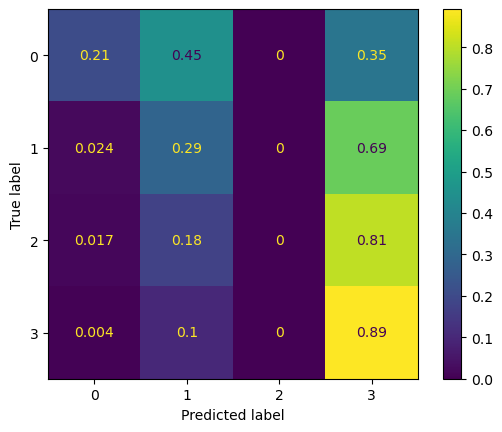

In [161]:
ConfusionMatrixDisplay.from_predictions(
    ratings, preds, labels=[0, 1, 2, 3], normalize='true'
)

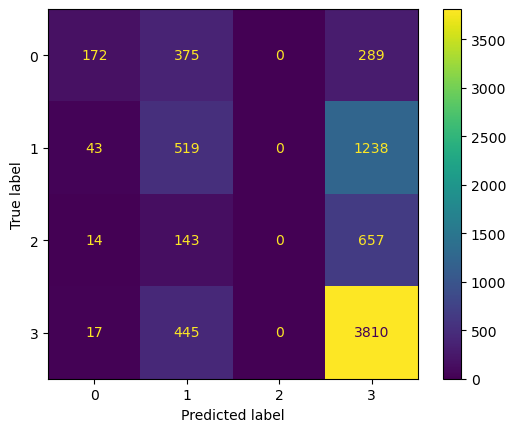

In [163]:
ConfusionMatrixDisplay.from_predictions(
    ratings, preds, labels=[0, 1, 2, 3]
)

In [145]:
### K-fold ensemble for if bechdel rating > 1 and > 2 ###

k_folds = 10
partition = (len(movie_data) // k_folds) + 1
indices = np.arange(0, len(movie_data))
np.random.shuffle(indices)

ord_models = []
for curr_k in range(k_folds):
    print("Fold", curr_k)

    val_indices = indices[partition*curr_k : partition*(curr_k+1)]
    mask = np.ones(len(movie_data), dtype=bool)
    mask[val_indices] = False
    train_indices = indices[mask]
    
    mod = OrderedModel(movie_data['ordered_rating'][train_indices], movie_data.loc[train_indices, feat_columns], 
                       distr='probit').fit(method='bfgs')

    train_pred = mod.predict(movie_data.loc[train_indices, feat_columns]).to_numpy()
    val_pred = mod.predict(movie_data.loc[val_indices, feat_columns]).to_numpy()
    train_acc = (ratings[train_indices] == train_pred.argmax(axis=1)).sum() / len(ratings[train_indices])
    val_acc = (ratings[val_indices] == val_pred.argmax(axis=1)).sum() / len(ratings[val_indices])
    
    print("Train Accuracy:", train_acc, "Val Accuracy:", val_acc)
    
    ord_models.append(mod)

Fold 0
Optimization terminated successfully.
         Current function value: 1.005231
         Iterations: 100
         Function evaluations: 106
         Gradient evaluations: 106
Train Accuracy: 0.5839689163908476 Val Accuracy: 0.5912031047865459
Fold 1
Optimization terminated successfully.
         Current function value: 1.008324
         Iterations: 92
         Function evaluations: 98
         Gradient evaluations: 98
Train Accuracy: 0.5815225212260757 Val Accuracy: 0.5912031047865459
Fold 2
Optimization terminated successfully.
         Current function value: 1.004382
         Iterations: 99
         Function evaluations: 105
         Gradient evaluations: 105
Train Accuracy: 0.5838250107929198 Val Accuracy: 0.5937904269081501
Fold 3
Optimization terminated successfully.
         Current function value: 1.005778
         Iterations: 99
         Function evaluations: 105
         Gradient evaluations: 105
Train Accuracy: 0.5839689163908476 Val Accuracy: 0.5873221216041398
Fold 

In [151]:
def ensemble_predict(model_list, testdata):
    preds = np.zeros(len(testdata))
    for model in model_list:
        out = model.predict(testdata).to_numpy().argmax(axis=1)
        preds = preds + out
    return preds / len(model_list)
    
ens_preds = ensemble_predict(ord_models, movie_data[feat_columns])

In [153]:
(ratings == ens_preds).sum() / len(ratings)

0.5637140637140637

(array([ 226.,   23.,   25., 1318.,   77.,   38.,   28.,   26.,   68.,
        5893.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

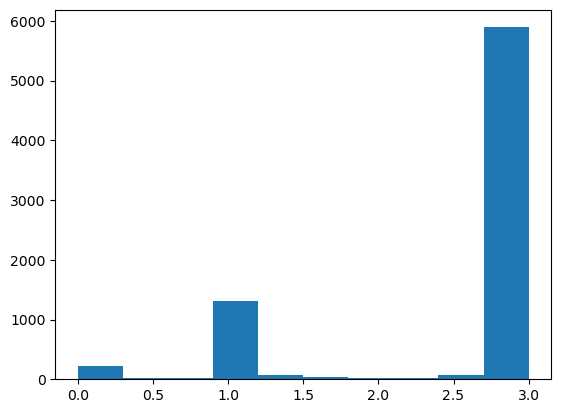

In [162]:
plt.hist(ens_preds)

## Graph Self-Supervised Learning

Unable to learn, abandoned.

In [2]:
class MovieGalaxiesDataset(Dataset):
    """
    Dataset for MovieGalaxies that also aggregates additional metadata
    """
    
    def __init__(self, root, graph_root, split='train', transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        
        # I'm the only one going to be using these so I didn't bother making it generalizable
        # load
        metadata = pd.read_csv(root + "MoviesDataset/movies_metadata.csv")
        links = pd.read_csv(root + "MoviesDataset/links.csv")
        bechedel_data = pd.read_json(root + "bechedeltest.json", orient='records')
        galaxies_metadata = pd.read_table(root + "MovieGalaxies/network_metadata.tab")

        # cleaning
        movie_data = metadata[~pd.isnull(metadata['imdb_id'])]
        movie_data['imdb_id'] = movie_data['imdb_id'].apply(lambda x: x[2:])
        galaxies_metadata['IMDB_id'] = galaxies_metadata['IMDB_id'].apply(lambda x: x[2:])

        # add bechedel data info
        movie_data = pd.merge(movie_data, bechedel_data, left_on='imdb_id', right_on='imdbid', how='inner')
        
        # split those with metadata and those without
        all_galaxies = pd.merge(galaxies_metadata, movie_data, how='left', left_on='IMDB_id', right_on='imdb_id')
        all_galaxies_with_meta = all_galaxies[~pd.isna(all_galaxies['imdb_id'])]
        all_galaxies_no_meta = all_galaxies[pd.isna(all_galaxies['imdb_id'])]
        all_galaxies_no_meta = pd.merge(galaxies_metadata, all_galaxies_no_meta[['IMDB_id']], how='inner', on='IMDB_id')
        
        save_columns = [
            'GexfID', 'Title', 'IMDB_id', 'ReleaseDate', 'WeightedDegree', 
            'Modularity', 'PathLength', 'Diameter', 'ClusteringCoefficient', 
            'ConnectedComponents', 'Density', 'genres', 'popularity', 'overview', 
            'runtime', 'vote_average', 'vote_count', 'rating'
        ]
        convert_columns = [
            'WeightedDegree', 'Modularity', 'PathLength', 'Diameter', 'ClusteringCoefficient', 
            'ConnectedComponents', 'Density'
        ]

        all_galaxies_with_meta = all_galaxies_with_meta[save_columns]
        for col in convert_columns:
            all_galaxies_with_meta[col] = all_galaxies_with_meta[col].apply(lambda x: float(x.replace(',', '.')))

        num_columns = [
            'ReleaseDate', 'WeightedDegree', 'Modularity', 'PathLength', 'Diameter', 
            'ClusteringCoefficient', 'ConnectedComponents', 'Density', 'popularity', 
            'runtime', 'vote_average', 'vote_count'
        ]
        all_galaxies_with_meta['genres'] = all_galaxies_with_meta['genres'].apply(
            lambda x: " ".join([y['name'] for y in ast.literal_eval(x)]))

        self.graph_features = torch.from_numpy(all_galaxies_with_meta[num_columns].to_numpy())
        self.meta_dataframe = all_galaxies_with_meta
        
        # Load GPT2Tokenizer
        tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        
        # tokenizer genres
        self.genres = self.meta_dataframe['genres'].apply(lambda x: tokenizer.encode(x)).tolist()
        
        # load networks
        self.networks = []
        for gid in tqdm(range(len(self.meta_dataframe))):
            filename = graph_root + "graph" + str(self.meta_dataframe.iloc[gid]['GexfID']) + ".graphml"
            graph = nx.read_graphml(filename)
            
            graph = self._cleanup_graph(graph, tokenizer)
            graph.graph['bechdel_labels'] = self._ordinal_ratings(self.meta_dataframe.iloc[gid]['rating'])
            graph.graph['rating'] = self.meta_dataframe.iloc[gid]['rating']
            
            torch_graph = from_networkx(graph)
            torch_graph.num_nodes = len(torch_graph.x)
            self.networks.append(torch_graph)
            
    def _ordinal_ratings(self, rating):
        # P(R > 0), P(R > 1), P(R > 2)
        rating_labels = [int(rating > 0), int(rating > 1), int(rating > 2)]
        return [rating_labels]
    
    def _cleanup_graph(self, graph, text_encoder):
        graph.graph.pop('node_default')
        graph.graph.pop('edge_default')
        
        for v in graph.nodes:

            # encode name
            graph.nodes[v]['name'] = text_encoder.encode(graph.nodes[v]['name'].lower())
            
            x = []
            for key in graph.nodes[v].keys():
                if key != 'name':
                    x.append(graph.nodes[v][key])

            graph.nodes[v]['x'] = x
            
        return graph
    
    def len(self):
        return len(self.networks)
    
    def get(self, idx):
        self.networks[idx].name = [list(x) for x in self.networks[idx].name]
        self.networks[idx].graph_features = self.graph_features[idx]
        self.networks[idx].genres = self.genres[idx]
        return self.networks[idx]

In [46]:
### Models ###

class GraphFeatureEncoder(nn.Module):
    """
    Uses the GPT2 pretrained Embedding and a self attention layer
    to combine the name embeddings of varying sizes into the same size.
    """
    def __init__(self, gpt2_type="gpt2"):
        super(GraphFeatureEncoder, self).__init__()
        gpt2_model = GPT2Model.from_pretrained(gpt2_type)
        self.embedding = gpt2_model.wte
        self.attention = nn.MultiheadAttention(embed_dim=768, num_heads=4, batch_first=True)
        
    def forward(self, batch):
        batch_idx = batch.batch
        bs = batch.batch.max().item() + 1
        graph_features = batch.graph_features.reshape(bs, -1)
        
        genres = batch.genres
        x = batch.x.to(device)
        embedded_graphfeat = []
        # Unfortunately can't parallelize this since they're of varying sizes and gpt2 traditionally does not
        # use padding

        for b in range(len(genres)):
            # get graph features for this node
            node_graph_features = graph_features[batch_idx[b]]
                
            # create embeddings for genre
            embedded = self.embedding(torch.Tensor(genres[b]).int().to(device))
            attn_output, _ = self.attention(embedded.unsqueeze(0), embedded.unsqueeze(0), embedded.unsqueeze(0))
            node_graph_features = torch.cat((node_graph_features, attn_output.sum(dim=1).squeeze()))
            embedded_graphfeat.append(node_graph_features)
        
        embedded_graphfeat = torch.stack(embedded_graphfeat).squeeze()
        node_graphfeat = torch.index_select(embedded_graphfeat, dim=0, index=batch_idx)
        
        x = torch.hstack([x, node_graphfeat])
        return x

class MovieGraphNetwork(nn.Module):
    """
    A modified Graph Attention Network.
    Has an initial module for embedding names with the GPT2 embeddings.
    Does graph classification.
    """
    def __init__(self, feat_dim, hidden_dim, heads, n_graph_layers, out_channels):
        super(MovieGraphNetwork, self).__init__()

        self.graph_encoder = GraphFeatureEncoder("gpt2")
        self.convs = nn.ModuleList()
        self.acts = nn.ModuleList()
        self.n_graph_layers = n_graph_layers
        self.classifier = nn.Linear(hidden_dim, out_channels)

        a = nn.LeakyReLU()
        for i in range(self.n_graph_layers):
            start_dim = hidden_dim if i else feat_dim
            conv = GATConv(start_dim, hidden_dim, heads=heads, edge_dim=1, concat=False)
            self.convs.append(conv)
            self.acts.append(a)
            
        self.graph_dense = nn.Linear(hidden_dim, hidden_dim)
        self.a = nn.LeakyReLU()

    def forward(self, batch):
        edge_index = batch.edge_index.to(device)
        edge_attr = batch.weight.to(device).double()
        
        x = self.graph_encoder(batch)
        
        for i in range(self.n_graph_layers):
            x = self.convs[i](x, edge_index, edge_attr)
            x = self.acts[i](x)
        
        # save node embeddings for ssl
        features = x
        
        # pool together for graph level features
        x = global_add_pool(x, batch.batch)
        
        # now use batch.graph_features and batch.
        x = self.graph_dense(x)
        x = self.a(x)
        x = self.classifier(x)
        return x, features
    
        
def init_weights(m):
    """
    Initialize the weights of the network.
    """
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [4]:
### torch_geometric utils ###
def dropout_edge(edge_index: torch.Tensor, p: float = 0.5,
                 force_undirected: bool = False,
                 training: bool = True) -> Tuple[torch.Tensor, torch.Tensor]:
    r"""Randomly drops edges from the adjacency matrix
    :obj:`edge_index` with probability :obj:`p` using samples from
    a Bernoulli distribution.
    The method returns (1) the retained :obj:`edge_index`, (2) the edge mask
    or index indicating which edges were retained, depending on the argument
    :obj:`force_undirected`.
    Args:
        edge_index (LongTensor): The edge indices.
        p (float, optional): Dropout probability. (default: :obj:`0.5`)
        force_undirected (bool, optional): If set to :obj:`True`, will either
            drop or keep both edges of an undirected edge.
            (default: :obj:`False`)
        training (bool, optional): If set to :obj:`False`, this operation is a
            no-op. (default: :obj:`True`)
    :rtype: (:class:`LongTensor`, :class:`BoolTensor` or :class:`LongTensor`)
    Examples:
        >>> edge_index = torch.tensor([[0, 1, 1, 2, 2, 3],
        ...                            [1, 0, 2, 1, 3, 2]])
        >>> edge_index, edge_mask = dropout_edge(edge_index)
        >>> edge_index
        tensor([[0, 1, 2, 2],
                [1, 2, 1, 3]])
        >>> edge_mask # masks indicating which edges are retained
        tensor([ True, False,  True,  True,  True, False])
        >>> edge_index, edge_id = dropout_edge(edge_index,
        ...                                    force_undirected=True)
        >>> edge_index
        tensor([[0, 1, 2, 1, 2, 3],
                [1, 2, 3, 0, 1, 2]])
        >>> edge_id # indices indicating which edges are retained
        tensor([0, 2, 4, 0, 2, 4])
    """
    if p < 0. or p > 1.:
        raise ValueError(f'Dropout probability has to be between 0 and 1 '
                         f'(got {p}')

    if not training or p == 0.0:
        edge_mask = edge_index.new_ones(edge_index.size(1), dtype=torch.bool)
        return edge_index, edge_mask

    row, col = edge_index

    edge_mask = torch.rand(row.size(0), device=edge_index.device) >= p

    if force_undirected:
        edge_mask[row > col] = False

    edge_index = edge_index[:, edge_mask]

    if force_undirected:
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
        edge_mask = edge_mask.nonzero().repeat((2, 1)).squeeze()

    return edge_index, edge_mask

In [5]:
### SSL Managers ###

class Base:
    def __init__(self, device):
        self.device = device
        self.cached_adj_norm = None

    def get_adj_norm(self, adj):
        if self.cached_adj_norm is None:
            adj_norm = preprocess_adj(adj, self.device)
            self.cached_adj_norm= adj_norm
        return self.cached_adj_norm

    def make_loss(self, embeddings):
        return 0

    def transform_data(self, adj, features):
        return self.get_adj_norm(adj), features
    
class EdgeMask(Base):
    def __init__(self, nhid, device):
        super(EdgeMask, self).__init__(device)
        self.masked_edges = None
        self.pseudo_labels = None
        self.linear = nn.Linear(nhid, 2).to(device)

    def make_loss(self, node_features, graphs, mask_ratio=0.5):
        """
        link prediction loss
        """
        new_edges, mask = dropout_edge(graphs.edge_index, p=mask_ratio, force_undirected=False, training=True)
        edges = new_edges
        
        neg_edges = batched_negative_sampling(edges, graphs.batch, num_neg_samples=None, force_undirected=True)
        
        pseudo_labels = np.zeros(edges.shape[1] + neg_edges.shape[1])
        pseudo_labels[: edges.shape[1]] = 1
        pseudo_labels = torch.LongTensor(pseudo_labels).to(device)

        embeddings_real = node_features[edges]
        embeddings_fake = node_features[neg_edges]
        embeddings0 = torch.cat([embeddings_real, embeddings_fake], dim=1)[0]
        embeddings1 = torch.cat([embeddings_real, embeddings_fake], dim=1)[1]

        embeddings = self.linear(torch.abs(embeddings0 - embeddings1).float())
        output = F.log_softmax(embeddings, dim=1)

        loss = F.nll_loss(output, pseudo_labels)

        return loss

                
def preprocess_features(features, device):
    return features.to(device)

def preprocess_adj(adj, device):
    # adj_normalizer = fetch_normalization(normalization)
    adj_normalizer = aug_normalized_adjacency
    r_adj = adj_normalizer(adj)
    r_adj = sparse_mx_to_torch_sparse_tensor(r_adj).float()
    r_adj = r_adj.to(device)
    return r_adj

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

def aug_normalized_adjacency(adj):
    adj = adj + sp.eye(adj.shape[0])
    adj = sp.coo_matrix(adj)
    row_sum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(row_sum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt).tocoo()

In [71]:
def train(model, optimizer, batch):
    # clear 
    optimizer.zero_grad()
    
    # forward pass
    out, main_features = model(batch)

    # get labels
    labels = batch.bechdel_labels.float().to(device)
    
    # loss and backwards
    ssloss = 0 #augmenter.make_loss(main_features, batch)
    
    predloss = criterion(out, labels)
    loss = predloss + ssloss
    loss.backward()
    optimizer.step()
    
    return loss.detach().item(), ssloss, predloss.detach().item()

def test(model, optimizer, loader):    
    total = 0
    total_correct = 0
    with tqdm(desc="Iterations", total=12, leave=False) as t:
        for batch in loader:
            # get predictions
            with torch.no_grad():
                out, _ = model(batch)

            preds = torch.sigmoid(out)
            preds = (out > 0.5).int().sum(dim=1)
            #pred0 = 1 - preds[:,0]
            #pred1 = preds[:,0] - preds[:,1]
            #pred2 = preds[:,1] - preds[:,2]
            #pred3 = preds[:,2]

            #ratings = torch.vstack([pred0, pred1, pred2, pred3])
            ratings = preds #ratings.argmax(dim=0)

            # labels and num correct
            labels = batch.rating
            correct = ratings == labels
            total_correct += int(correct.sum())
            total += len(batch.rating)
            t.update()
    
    test_acc = total_correct / total
    return test_acc * 100

In [80]:
### Training Hyperparameters ###
lr = 1e-3
bs = 50

num_layers = 8
num_classes = 3 # 3 levels for ordinal prediction
hidden_dim = 256
num_heads = 4
epochs = 20
sigmoid = nn.Sigmoid()
self_supervise = True

criterion = nn.BCEWithLogitsLoss()
#augmenter = EdgeMask(hidden_dim, device)

In [44]:
### Create Dataset ###
dataset = MovieGalaxiesDataset("data/", "data/MovieGalaxies/gender_labelled/")
train_loader = DataLoader(dataset, batch_size=bs, shuffle=True)

C:\Users\shirl\AppData\Local\Temp\ipykernel_67196\3577452519.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data['imdb_id'] = movie_data['imdb_id'].apply(lambda x: x[2:])


  0%|          | 0/594 [00:00<?, ?it/s]

In [81]:
### Create Model ###

# 768 from GPT2, 7 node level, 15?? graph level
model = MovieGraphNetwork(788, hidden_dim, num_heads, num_layers, num_classes)
model = model.double()
model = model.apply(init_weights)

### Create Optimizer ###
# + list(augmenter.linear.parameters())
optimizer = torch.optim.Adam(list(model.parameters()), lr=lr, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [82]:
losses = []
accuracies = []
for epoch in trange(epochs, desc='Epochs'):
    # training
    model.train()

    with tqdm(desc="Iterations", total=12, leave=False) as t:
        for idx, batch in enumerate(train_loader):
            loss, ssloss, predloss = train(model, optimizer, batch)
            losses.append(loss)
            t.set_postfix(loss=round(float(loss), 4), ssl=round(float(ssloss), 4), pred=round(float(predloss), 4))
            t.update()

    # validation
    model.eval()
    acc = test(model, optimizer, train_loader)
    accuracies.append(acc)

    print(f'Epoch: {epoch+1}, Accuracy: {acc:.4f}')

    scheduler.step()

    if accuracies[-1] > 75 and accuracies[-1] < (max(accuracies) - 1) and epoch > 10:
        print("Stopping Early")
        break

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Iterations:   0%|          | 0/12 [00:00<?, ?it/s]

Iterations:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 1, Accuracy: 18.1818


Iterations:   0%|          | 0/12 [00:00<?, ?it/s]

Iterations:   0%|          | 0/12 [00:00<?, ?it/s]

KeyboardInterrupt: 

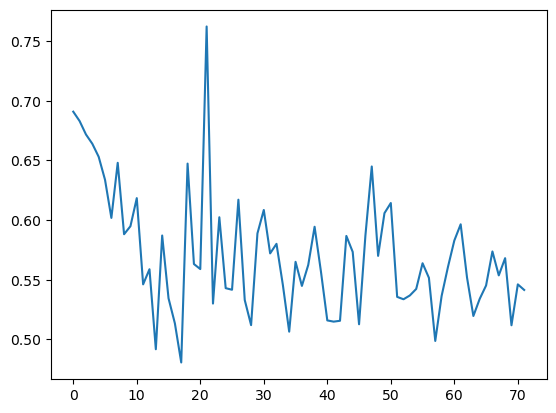

In [75]:
plt.plot(losses)

In [76]:
for batch in train_loader:
    break
    
out, features = model(batch)

In [77]:
preds = torch.sigmoid(out)
preds = (out > 0.5).int().sum(dim=1)

preds

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1,
        1, 1])

In [78]:
batch.rating

tensor([3., 2., 0., 0., 3., 3., 3., 3., 3., 1., 3., 1., 1., 1., 3., 3., 3., 3.,
        3., 0., 1., 1., 3., 3., 1., 1., 1., 2., 3., 3., 1., 0., 1., 3., 1., 1.,
        3., 0., 3., 1., 0., 3., 2., 3., 1., 2., 2., 3., 3., 3.],
       dtype=torch.float64)

In [79]:
torch.sigmoid(out)

tensor([[0.9674, 0.6197, 0.3901],
        [0.9653, 0.6156, 0.3858],
        [0.9068, 0.5831, 0.4287],
        [0.8081, 0.5537, 0.4559],
        [0.8690, 0.5695, 0.4406],
        [0.9176, 0.5870, 0.4231],
        [0.9526, 0.6065, 0.4023],
        [0.9015, 0.5807, 0.4299],
        [0.9266, 0.5919, 0.4199],
        [0.9628, 0.6143, 0.3932],
        [0.9679, 0.6176, 0.3787],
        [0.9894, 0.6536, 0.3427],
        [0.8956, 0.5785, 0.4321],
        [0.9675, 0.6190, 0.3879],
        [0.9172, 0.5877, 0.4248],
        [0.9462, 0.6020, 0.4069],
        [0.9264, 0.5922, 0.4207],
        [0.9894, 0.6517, 0.3355],
        [0.9495, 0.6029, 0.4014],
        [0.9310, 0.5942, 0.4176],
        [0.9584, 0.6086, 0.3883],
        [0.9652, 0.6176, 0.3927],
        [0.9220, 0.5898, 0.4221],
        [0.9425, 0.6007, 0.4110],
        [0.9386, 0.5987, 0.4141],
        [0.9990, 0.7173, 0.2350],
        [0.9745, 0.6257, 0.3744],
        [0.7878, 0.5491, 0.4597],
        [0.9550, 0.6095, 0.4028],
        [0.917

In [23]:
pred

tensor([[0.8705, 0.5546, 0.4234],
        [0.8651, 0.5535, 0.4252],
        [0.8758, 0.5558, 0.4217],
        [0.8685, 0.5542, 0.4241],
        [0.8792, 0.5566, 0.4206],
        [0.8675, 0.5540, 0.4244],
        [0.8868, 0.5584, 0.4179],
        [0.8902, 0.5592, 0.4166],
        [0.8666, 0.5538, 0.4247],
        [0.8912, 0.5595, 0.4163],
        [0.8710, 0.5547, 0.4233],
        [0.8726, 0.5551, 0.4228],
        [0.8689, 0.5543, 0.4240],
        [0.8653, 0.5535, 0.4251],
        [0.8642, 0.5533, 0.4255],
        [0.8641, 0.5533, 0.4255],
        [0.8643, 0.5533, 0.4254],
        [0.8662, 0.5537, 0.4248],
        [0.8705, 0.5546, 0.4235],
        [0.8904, 0.5593, 0.4166],
        [0.8693, 0.5544, 0.4239],
        [0.8724, 0.5551, 0.4228],
        [0.8809, 0.5570, 0.4200],
        [0.8726, 0.5551, 0.4228],
        [0.8709, 0.5547, 0.4233],
        [0.8812, 0.5571, 0.4199],
        [0.8676, 0.5540, 0.4244],
        [0.8644, 0.5533, 0.4254],
        [0.8650, 0.5535, 0.4252],
        [0.864

In [33]:
all_ratings = []
for batch in train_loader:
    all_ratings.append(batch.bechdel_labels)
    


In [34]:
all_ratings = torch.cat(all_ratings)

In [35]:
all_ratings[:,0].sum(), all_ratings[:,1].sum(), all_ratings[:,2].sum()

(tensor(548), tensor(363), tensor(270))

In [36]:
all_ratings.shape

torch.Size([594, 3])

In [53]:
548 / 594, 363/594, 270/594

(0.9225589225589226, 0.6111111111111112, 0.45454545454545453)

In [ ]:
# training hyperparameters
lr = 1e-4
bs = 50
num_layers = 4
num_classes = 2 # M/F
hidden_dim = 256
num_heads = 4
epochs = 20
sigmoid = nn.Sigmoid()

dataset = MovieGalaxiesDataset("data/")
partition = (len(dataset) // k_folds) + 1
indices = np.arange(0, len(dataset))
#np.random.shuffle(indices)

# create loss (weighting is important)
weights = torch.Tensor([6, 1]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight = weights)